<a href="https://colab.research.google.com/github/nshkwon/GNN-Project/blob/main/GCN%2BGRU_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import numpy as np




# Hyperparameters
batch_size = 64
input_sequence_length = 12
forecast_horizon = 3
multi_horizon = False
sigma2 = 0.1
epsilon = 0.5
epochs = 30
n_temporal_hidden=20
n_spatial_hidden=20
num_gru_layers=5
dropout=0.6

route_distances = pd.read_csv('PeMSD7_W_228.csv', header=None).to_numpy()  # (N, N)  (228, 228)
speeds_array = pd.read_csv('PeMSD7_V_228.csv', header=None).to_numpy()     # (T, N)  (12672, 228)



# sampling
sample_routes = [
    0,
    1,
    4,
    7,
    8,
    11,
    15,
    108,
    109,
    114,
    115,
    118,
    120,
    123,
    124,
    126,
    127,
    129,
    130,
    132,
    133,
    136,
    139,
    144,
    147,
    216,
]



route_distances = route_distances[np.ix_(sample_routes, sample_routes)]  #  (228, 228) - >  (26, 26)
speeds_array = speeds_array[:, sample_routes]                            #  (12672, 228) -> (12672, 26)




In [ ]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import argparse

#dataset
class TimeSeriesForecastDataset(Dataset):

    def __init__(self, data_array, input_sequence_length, forecast_horizon, multi_horizon=True):

        self.data = data_array
        self.input_sequence_length = input_sequence_length
        self.forecast_horizon = forecast_horizon
        self.multi_horizon = multi_horizon

    def __len__(self):

        return len(self.data) - self.input_sequence_length - self.forecast_horizon + 1

    def __getitem__(self, index):

        inputs = self.data[index:index+self.input_sequence_length]

        if self.multi_horizon:
            targets = self.data[index+self.input_sequence_length:index+self.input_sequence_length+self.forecast_horizon]
        else:
            targets = self.data[index+self.input_sequence_length+self.forecast_horizon-1]

        return torch.Tensor(inputs).unsqueeze(-1), torch.Tensor(targets)



def get_args():
    # argparse library to mange parameters
    parser = argparse.ArgumentParser(description='PyTorch FixMatch Training')

    parser.add_argument('--gat_or_gcn', type=str, default='gcn')
    parser.add_argument('--n-temporal-hidden', type=int, default=64)
    parser.add_argument('--n-spatial-hidden', type=int, default=64)
    parser.add_argument('--num-gru-layers', type=int, default=3)
    parser.add_argument('--nclass', type=int, default=3)
    parser.add_argument('--dropout', type=float, default=0.6)
    parser.add_argument('--alpha', type=float, default=0.2)
    parser.add_argument('--nheads', type=int, default=1)
    parser.add_argument('--lr', type=float, default=0.001)
    parser.add_argument('--weight-decay', type=float, default=0.0001)

    args = parser.parse_args()
    return args



def timeseries_dataset_from_array(data_array, input_sequence_length, forecast_horizon, batch_size, shuffle=True, multi_horizon=True):

    dataset = TimeSeriesForecastDataset(data_array, input_sequence_length, forecast_horizon, multi_horizon)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return dataloader


def preprocess(data_array: np.ndarray, train_size: float, val_size: float):
    """Splits data into train/val/test sets and normalizes the data.

    Adapted from Keras code example for timeseries traffic forecasting
    Source: [https://keras.io/examples/timeseries/timeseries_traffic_forecasting/]

    """

    num_time_steps = data_array.shape[0]
    num_train, num_val = (
        int(num_time_steps * train_size),
        int(num_time_steps * val_size),
    )
    train_array = data_array[:num_train]
    mean, std = train_array.mean(axis=0), train_array.std(axis=0)

    train_array = (train_array - mean) / std
    val_array = (data_array[num_train : (num_train + num_val)] - mean) / std
    test_array = (data_array[(num_train + num_val) :] - mean) / std

    return train_array, val_array, test_array


def compute_adjacency_matrix(
    route_distances: np.ndarray, sigma2: float, epsilon: float
):
    """Computes the adjacency matrix from distances matrix.

    It uses the formula in https://github.com/VeritasYin/STGCN_IJCAI-18#data-preprocessing to
    compute an adjacency matrix from the distance matrix.
    The implementation follows that paper.
    Adapted from Keras code example for timeseries traffic forecasting
    Source: [https://keras.io/examples/timeseries/timeseries_traffic_forecasting/]

    """
    num_routes = route_distances.shape[0]
    route_distances = route_distances / 10000.0
    w2, w_mask = (
        route_distances * route_distances,
        np.ones([num_routes, num_routes]) - np.identity(num_routes),
    )
    return (np.exp(-w2 / sigma2) >= epsilon) * w_mask

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import numpy as np


#GCN
class GCNLayer(nn.Module):
    def __init__(self, in_features, out_features, adjacency_matrix):
        super(GCNLayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features

        self.fc = nn.Linear(in_features, out_features)
        self.A = adjacency_matrix

    def forward(self, x):
        return self.fc(torch.matmul(self.A, x))

class SpatioTemporalGCN(nn.Module):
    def __init__(self, input_sequence_length, n_temporal_hidden, n_spatial_hidden, num_gru_layers, nclass, A):
        super(SpatioTemporalGCN, self).__init__()
        self.input_sequence_length = input_sequence_length

        self.n_temporal_hidden = n_temporal_hidden
        self.n_spatial_hidden = n_spatial_hidden
        self.num_gru_layers = num_gru_layers
        self.nclass = nclass

        # GRU layer
        self.gru = nn.GRU(1, n_temporal_hidden, num_gru_layers, batch_first=True)

        self.feature_extractor = nn.Sequential(
                                    GCNLayer(n_temporal_hidden, n_spatial_hidden, A),
                                    nn.ReLU(),
                                    GCNLayer(n_spatial_hidden, n_spatial_hidden, A)
                                )
        self.linear = nn.Linear(n_spatial_hidden, nclass)

    def forward(self, x):
        x = x.permute(0, 2, 1, 3)

        # batch_size, num_routes, input_sequence_length, n_temporal_features
        B, R, N, S = x.size()

        # GRU to handle temporal information
        x = x.reshape(B*R, N, S)
        _, h_n = self.gru(x)
        x = h_n[-1]
        x = x.view(B, R, self.n_temporal_hidden)  # shape: (batch_size, num_routes, self.n_temporal_hidden)
        x = F.dropout(x, training=self.training)

        # Here is the different part from the GAT+GRU model. GCN is used instead of GAT.
        # ###########################################
        self.feature_extractor(x)
        x = F.dropout(x, training=self.training)

        x = self.linear(x)
        #############################################

        return x


train set size: (6336, 26)
validation set size: (2534, 26)
test set size: (3802, 26)
route_distances shape=(26, 26)
speeds_array shape=(12672, 26)
Using device: cuda:0
Test Loss: 0.1362
Epoch [1/30] : Train Loss: 0.3025  /  Validation Loss: 0.1341 / Test Loss: 0.1362
Test Loss: 0.1119
Epoch [2/30] : Train Loss: 0.2047  /  Validation Loss: 0.1086 / Test Loss: 0.1119
Test Loss: 0.1074
Epoch [3/30] : Train Loss: 0.2034  /  Validation Loss: 0.1030 / Test Loss: 0.1074
Test Loss: 0.0867
Epoch [4/30] : Train Loss: 0.2023  /  Validation Loss: 0.0816 / Test Loss: 0.0867
Test Loss: 0.0872
Epoch [5/30] : Train Loss: 0.2070  /  Validation Loss: 0.0815 / Test Loss: 0.0872
Test Loss: 0.1015
Epoch [6/30] : Train Loss: 0.2035  /  Validation Loss: 0.0966 / Test Loss: 0.1015
Test Loss: 0.1072
Epoch [7/30] : Train Loss: 0.2024  /  Validation Loss: 0.1034 / Test Loss: 0.1072
Test Loss: 0.0964
Epoch [8/30] : Train Loss: 0.2068  /  Validation Loss: 0.0926 / Test Loss: 0.0964
Test Loss: 0.0940
Epoch [9/30] :

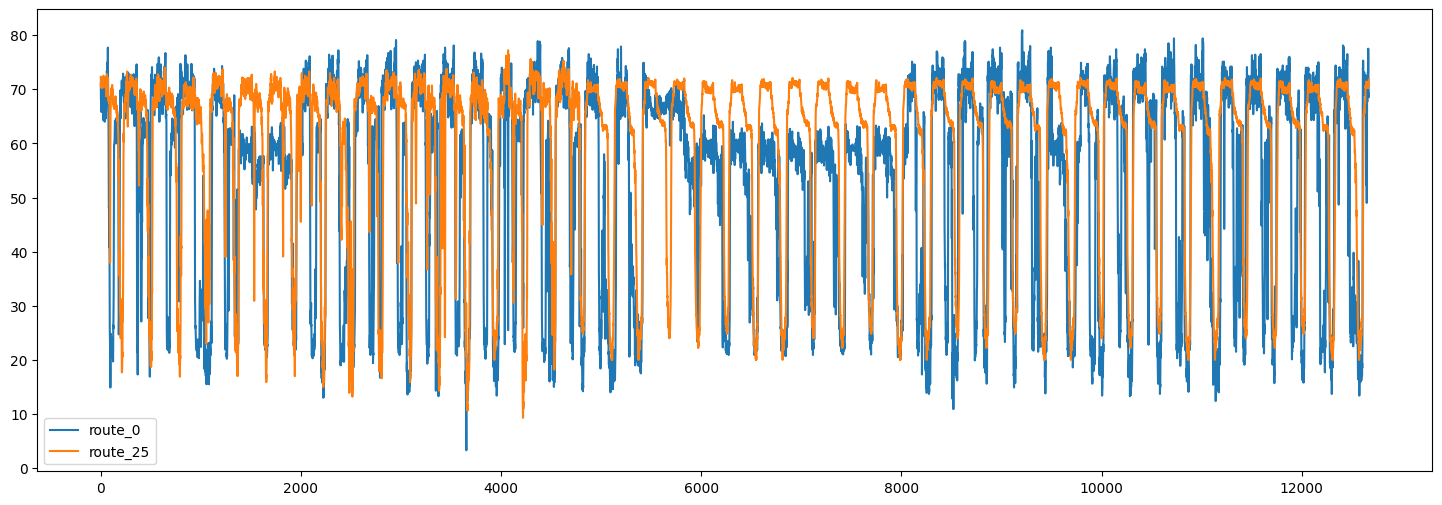

In [ ]:
import matplotlib.pyplot as plt

train_size, val_size = 0.5, 0.2
train_array, val_array, test_array = preprocess(speeds_array, train_size, val_size)

print(f"train set size: {train_array.shape}") #  (6336, 26)
print(f"validation set size: {val_array.shape}") # (2534, 26)
print(f"test set size: {test_array.shape}") # (3802, 26)
print(f"route_distances shape={route_distances.shape}")
print(f"speeds_array shape={speeds_array.shape}")

plt.figure(figsize=(18, 6))
plt.plot(speeds_array[:, [0, -1]])
plt.legend(["route_0", "route_25"])

# CUDA
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

train_dataloader = timeseries_dataset_from_array(train_array, input_sequence_length=input_sequence_length, forecast_horizon=forecast_horizon, batch_size=batch_size, shuffle=True)
val_dataloader   = timeseries_dataset_from_array(val_array, input_sequence_length=input_sequence_length, forecast_horizon=forecast_horizon, batch_size=batch_size, shuffle=True)
test_dataloader  = timeseries_dataset_from_array(test_array, input_sequence_length=input_sequence_length, forecast_horizon=forecast_horizon, batch_size=test_array.shape[0], shuffle=False)
adjacency_matrix = compute_adjacency_matrix(route_distances, sigma2, epsilon)
adj_matrix_tensor = torch.from_numpy(adjacency_matrix).float()



model = SpatioTemporalGCN(
    input_sequence_length=input_sequence_length,
    n_temporal_hidden=n_temporal_hidden,
    n_spatial_hidden=n_spatial_hidden,
    num_gru_layers=num_gru_layers,
    nclass=forecast_horizon, A=adj_matrix_tensor.to(device))

criterion = torch.nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)


model.to(device)

# Training loop
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for batch_inputs, batch_targets in train_dataloader:
        batch_inputs, batch_targets = batch_inputs.to(device), batch_targets.to(device)

        optimizer.zero_grad()
        output = model(batch_inputs)
        loss = criterion(output.permute(0, 2, 1), batch_targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_dataloader)

    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_inputs, batch_targets in val_dataloader:
            batch_inputs, batch_targets = batch_inputs.to(device), batch_targets.to(device)
            output = model(batch_inputs)
            loss = criterion(output.permute(0, 2, 1), batch_targets)
            val_loss += loss.item()

    val_loss /= len(val_dataloader)


    # Test loop
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for batch_inputs, batch_targets in test_dataloader:
            batch_inputs, batch_targets = batch_inputs.to(device), batch_targets.to(device)
            output = model(batch_inputs)
            loss = criterion(output.permute(0, 2, 1), batch_targets)
            test_loss += loss.item()

        test_loss /= len(test_dataloader)
        print(f"Test Loss: {test_loss:.4f}")

    print(f"Epoch [{epoch+1}/{epochs}] : Train Loss: {train_loss:.4f}  /  Validation Loss: {val_loss:.4f} / Test Loss: {test_loss:.4f}")


model MAE: 0.13433104753494263
model MAPE: 0.9753354787826538
model RMSE: 0.20852649297366138


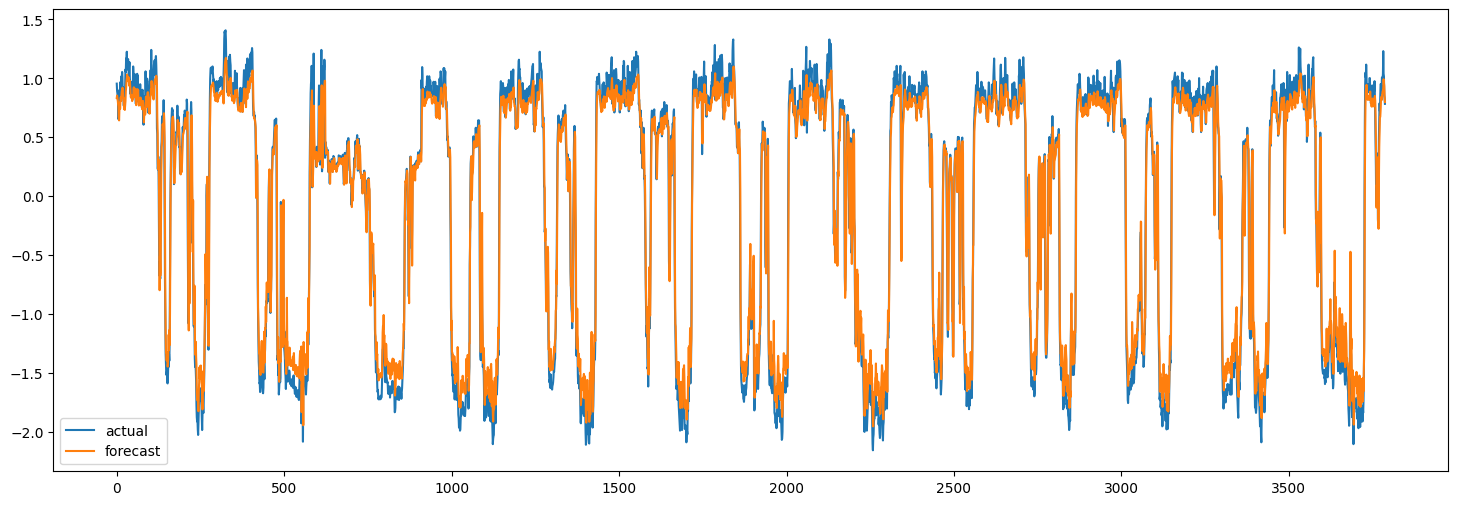

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error,  mean_absolute_error, mean_squared_error

for x_test, y in test_dataloader:
    batch_inputs = x_test.to(device)
    y_pred = model(batch_inputs)
    x_test = x_test.cpu().detach().numpy()
    y_pred = y_pred.permute(0, 2, 1).cpu().detach().numpy()
    y      = y.numpy()
    plt.figure(figsize=(18, 6))
    plt.plot(y[:, 0, 0])
    plt.plot(y_pred[:, 0, 0])
    plt.legend(["actual", "forecast"])

    print(f"model MAE: {mean_absolute_error(y[:,0,:], y_pred[:, 0, :])}")
    print(f"model MAPE: {mean_absolute_percentage_error(y[:,0,:], y_pred[:, 0, :])}")
    print(f"model RMSE: {mean_squared_error(y[:,0,:], y_pred[:, 0, :])**0.5}")

    break